## 用numpy实现简单的两层神经网络

梯度下降理解：https://blog.csdn.net/u014696921/article/details/61194741

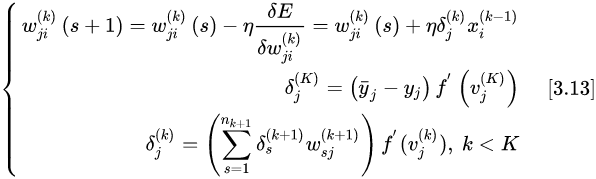

In [2]:
# -*- coding: utf-8 -*-
import numpy as np

# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 1000, 100, 10

# Create random input and output data
x = np.random.randn(N, D_in)
y = np.random.randn(N, D_out)

# Randomly initialize weights
w1 = np.random.randn(D_in, H)
w2 = np.random.randn(H, D_out)

learning_rate = 1e-6
for t in range(500):
    # Forward pass: compute predicted y
    h = x.dot(w1)
    h_relu = np.maximum(h, 0)
    y_pred = h_relu.dot(w2)

    # Compute and print loss
    loss = np.square(y_pred - y).sum()
    print(t, loss)

    # Backprop to compute gradients of w1 and w2 with respect to loss
    grad_y_pred = 2.0 * (y_pred - y)
    grad_w2 = h_relu.T.dot(grad_y_pred)
    grad_h_relu = grad_y_pred.dot(w2.T)
    grad_h = grad_h_relu.copy()
    grad_h[h < 0] = 0
    grad_w1 = x.T.dot(grad_h)

    # Update weights
    w1 -= learning_rate * grad_w1
    w2 -= learning_rate * grad_w2

## 使用 torch 实现上述代码

需要注意的几个点：
`torch.mm(mat1, mat2, out=None)`: 实现矩阵乘法 
`torch.clamp(input, min, max)`: 让张量中所有元素都保持在\[min,max\] 区间内


In [ ]:
# -*- coding: utf-8 -*-

import torch


dtype = torch.float
device = torch.device("cpu")
# device = torch.device("cuda:0") # Uncomment this to run on GPU

# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 1000, 100, 10

# Create random input and output data
x = torch.randn(N, D_in, device=device, dtype=dtype)
y = torch.randn(N, D_out, device=device, dtype=dtype)

# Randomly initialize weights
w1 = torch.randn(D_in, H, device=device, dtype=dtype)
w2 = torch.randn(H, D_out, device=device, dtype=dtype)

learning_rate = 1e-6
for t in range(500):
    # Forward pass: compute predicted y
    h = x.mm(w1)
    h_relu = h.clamp(min=0)  
    y_pred = h_relu.mm(w2)

    # Compute and print loss
    loss = (y_pred - y).pow(2).sum().item()
    print(t, loss)

    # Backprop to compute gradients of w1 and w2 with respect to loss
    grad_y_pred = 2.0 * (y_pred - y)
    grad_w2 = h_relu.t().mm(grad_y_pred)
    grad_h_relu = grad_y_pred.mm(w2.t())
    grad_h = grad_h_relu.clone()
    grad_h[h < 0] = 0
    grad_w1 = x.t().mm(grad_h)

    # Update weights using gradient descent
    w1 -= learning_rate * grad_w1
    w2 -= learning_rate * grad_w2

## 实现自动梯度

之前的代码是手动实现梯度的后向传播，这里使用Pytorch的自动梯度自动实现梯度传播

In [ ]:
# -*- coding: utf-8 -*-
import torch

dtype = torch.float
device = torch.device("cpu")
# device = torch.device("cuda:0") # Uncomment this to run on GPU

N, D_in, H, D_out = 64, 1000, 100, 10

x = torch.randn(N, D_in, device=device, dtype=dtype)
y = torch.randn(N, D_out, device=device, dtype=dtype)

w1 = torch.randn(D_in, H, device=device, dtype=dtype, requires_grad=True)
w2 = torch.randn(H, D_out, device=device, dtype=dtype, requires_grad=True)

learning_rate = 1e-6
for t in range(500):
    y_pred = x.mm(w1).clamp(min=0).mm(w2)

    loss = (y_pred - y).pow(2).sum()
    print(t, loss.item())

    # Use autograd to compute the backward pass. This call will compute the
    # gradient of loss with respect to all Tensors with requires_grad=True.
    # After this call w1.grad and w2.grad will be Tensors holding the gradient
    # of the loss with respect to w1 and w2 respectively.
    loss.backward()

    # Manually update weights using gradient descent. Wrap in torch.no_grad()
    # because weights have requires_grad=True, but we don't need to track this
    # in autograd.
    # An alternative way is to operate on weight.data and weight.grad.data.
    # Recall that tensor.data gives a tensor that shares the storage with
    # tensor, but doesn't track history.
    # You can also use torch.optim.SGD to achieve this.
    with torch.no_grad():
        w1 -= learning_rate * w1.grad
        w2 -= learning_rate * w2.grad

        # Manually zero the gradients after updating weights
        w1.grad.zero_()
        w2.grad.zero_()

## 使用Pytorch.nn 实现两层神经网络

In [3]:
# -*- coding: utf-8 -*-
import torch


N, D_in, H, D_out = 64, 1000, 100, 10

x = torch.randn(N, D_in)
y = torch.randn(N, D_out)

model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
)

loss_fn = torch.nn.MSELoss(reduction='sum')

learning_rate = 1e-4
for t in range(500):
    y_pred = model(x)

    loss = loss_fn(y_pred, y)
    print(t, loss.item())

    model.zero_grad()

    loss.backward()

    # Update the weights using gradient descent. Each parameter is a Tensor, so
    # we can access its gradients like we did before.
    with torch.no_grad():
        for param in model.parameters():
            param -= learning_rate * param.grad

0 643.28369140625
1 597.2950439453125
2 556.8828735351562
3 520.796142578125
4 488.4062805175781
5 459.2258605957031
6 432.7748107910156
7 408.33770751953125
8 385.5289306640625
9 364.169921875
10 344.2653503417969
11 325.7679138183594
12 308.38525390625
13 291.91009521484375
14 276.2677917480469
15 261.3163146972656
16 247.05361938476562
17 233.44827270507812
18 220.52520751953125
19 208.258056640625
20 196.55555725097656
21 185.43882751464844
22 174.8434600830078
23 164.78163146972656
24 155.19577026367188
25 146.1186981201172
26 137.5124053955078
27 129.33731079101562
28 121.60320281982422
29 114.26940155029297
30 107.36672973632812
31 100.87289428710938
32 94.75439453125
33 88.98796844482422
34 83.559326171875
35 78.45349884033203
36 73.65199279785156
37 69.14154815673828
38 64.9059066772461
39 60.92357635498047
40 57.19109344482422
41 53.689151763916016
42 50.41056823730469
43 47.34016418457031
44 44.46343231201172
45 41.76721954345703
46 39.24153137207031
47 36.880802154541016
48

395 7.430157711496577e-05
396 7.209385512396693e-05
397 6.995402509346604e-05
398 6.787633174099028e-05
399 6.586137897102162e-05
400 6.390771886799484e-05
401 6.201482028700411e-05
402 6.017503619659692e-05
403 5.83930013817735e-05
404 5.666098149958998e-05
405 5.4980813729343936e-05
406 5.335424066288397e-05
407 5.177417551749386e-05
408 5.024269921705127e-05
409 4.8757960030343384e-05
410 4.731717854156159e-05
411 4.59186194348149e-05
412 4.456163151189685e-05
413 4.324650944909081e-05
414 4.197130328975618e-05
415 4.0732964407652617e-05
416 3.95305069105234e-05
417 3.836559335468337e-05
418 3.7234021874610335e-05
419 3.613745138864033e-05
420 3.5071687307208776e-05
421 3.40399237757083e-05
422 3.303894118289463e-05
423 3.2064846891444176e-05
424 3.1123345252126455e-05
425 3.020418807864189e-05
426 2.931612471002154e-05
427 2.8455919164116494e-05
428 2.762027725111693e-05
429 2.6805480956682004e-05
430 2.601906999188941e-05
431 2.5256416847696528e-05
432 2.451376167300623e-05
433 2.

## 使用其他优化器优化模型

In [4]:
# -*- coding: utf-8 -*-
import torch

# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 1000, 100, 10

# Create random Tensors to hold inputs and outputs
x = torch.randn(N, D_in)
y = torch.randn(N, D_out)

# Use the nn package to define our model and loss function.
model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
)
loss_fn = torch.nn.MSELoss(reduction='sum')

# Use the optim package to define an Optimizer that will update the weights of
# the model for us. Here we will use Adam; the optim package contains many other
# optimization algoriths. The first argument to the Adam constructor tells the
# optimizer which Tensors it should update.
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
for t in range(500):
    # Forward pass: compute predicted y by passing x to the model.
    y_pred = model(x)

    # Compute and print loss.
    loss = loss_fn(y_pred, y)
    print(t, loss.item())

    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable
    # weights of the model). This is because by default, gradients are
    # accumulated in buffers( i.e, not overwritten) whenever .backward()
    # is called. Checkout docs of torch.autograd.backward for more details.
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()

0 695.9238891601562
1 678.3800659179688
2 661.4261474609375
3 644.9351196289062
4 628.90478515625
5 613.3997192382812
6 598.31005859375
7 583.52880859375
8 569.1648559570312
9 555.2843627929688
10 541.8772583007812
11 528.8619384765625
12 516.2294921875
13 503.99652099609375
14 492.0730895996094
15 480.4508361816406
16 469.14093017578125
17 458.1546936035156
18 447.4594421386719
19 437.10137939453125
20 427.000732421875
21 417.1375732421875
22 407.4768981933594
23 398.0486755371094
24 388.8899841308594
25 379.98077392578125
26 371.2334899902344
27 362.6468200683594
28 354.21588134765625
29 345.9257507324219
30 337.8188781738281
31 329.9184265136719
32 322.2074890136719
33 314.6590881347656
34 307.2610778808594
35 300.01043701171875
36 292.91754150390625
37 285.9495849609375
38 279.0962219238281
39 272.39044189453125
40 265.8233337402344
41 259.3749084472656
42 253.0572967529297
43 246.89080810546875
44 240.84866333007812
45 234.94166564941406
46 229.15016174316406
47 223.4879608154297


369 0.0003771348565351218
370 0.00036249152617529035
371 0.00034843155299313366
372 0.00033492734655737877
373 0.00032195402309298515
374 0.00030949435313232243
375 0.00029752214322797954
376 0.0002860495005734265
377 0.00027498567942529917
378 0.0002643777406774461
379 0.00025417658616788685
380 0.0002443832054268569
381 0.0002349685673834756
382 0.00022592837922275066
383 0.00021723764075431973
384 0.0002088883047690615
385 0.00020086603763047606
386 0.00019315406098030508
387 0.0001857435709098354
388 0.00017862294043879956
389 0.0001717728446237743
390 0.00016519696509931237
391 0.00015887411427684128
392 0.00015279340732377023
393 0.00014695426216349006
394 0.00014133923104964197
395 0.00013594118354376405
396 0.00013075326569378376
397 0.00012576814333442599
398 0.00012097253056708723
399 0.00011635934060905129
400 0.0001119296794058755
401 0.0001076648331945762
402 0.00010357092105550691
403 9.963364573195577e-05
404 9.584342478774488e-05
405 9.220342326443642e-05
406 8.87011410

## 重点：定制自己的网络模型

- 继承`nn.Module`类

- 重构函数`forward` 以获得输入张量和得到输出结果

In [ ]:
# -*- coding: utf-8 -*-
import torch


class TwoLayerNet(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(TwoLayerNet, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, D_out)

    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        h_relu = self.linear1(x).clamp(min=0)
        y_pred = self.linear2(h_relu)
        return y_pred


# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 1000, 100, 10

# Create random Tensors to hold inputs and outputs
x = torch.randn(N, D_in)
y = torch.randn(N, D_out)

# Construct our model by instantiating the class defined above
model = TwoLayerNet(D_in, H, D_out)

# Construct our loss function and an Optimizer. The call to model.parameters()
# in the SGD constructor will contain the learnable parameters of the two
# nn.Linear modules which are members of the model.
criterion = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)
for t in range(500):
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = model(x)

    # Compute and print loss
    loss = criterion(y_pred, y)
    print(t, loss.item())

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()